In [27]:
pip install pykalman

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [29]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [30]:
dig = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/DIG Historical Data.csv')
dxg = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/DXG Historical Data.csv')
nvl = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/NVL Historical Data.csv')

In [31]:
dig['Price'] = dig['Price'].str.replace('$', '', regex=True)
dig['Price'] = dig['Price'].str.replace(',', '', regex=True)
dig['Price'] = dig.Price.astype(float)
dig['Date'] = pd.to_datetime(dig['Date'])
dig=dig[::-1]

dxg['Price'] = dxg['Price'].str.replace('$', '', regex=True)
dxg['Price'] = dxg['Price'].str.replace(',', '', regex=True)
dxg['Price'] = dxg.Price.astype(float)
dxg['Date'] = pd.to_datetime(dxg['Date'])
dxg=dxg[::-1]

nvl['Price'] = nvl['Price'].str.replace('$', '', regex=True)
nvl['Price'] = nvl['Price'].str.replace(',', '', regex=True)
nvl['Price'] = nvl.Price.astype(float)
nvl['Date'] = pd.to_datetime(nvl['Date'])
nvl=nvl[::-1]

In [32]:
dig.set_index('Date', inplace=True)
dxg.set_index('Date', inplace=True)
nvl.set_index('Date', inplace=True)

<Axes: xlabel='Date'>

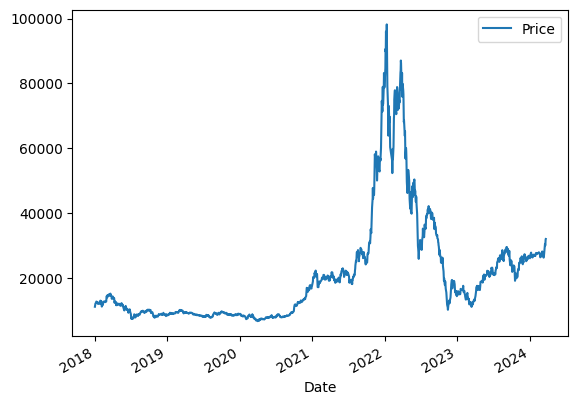

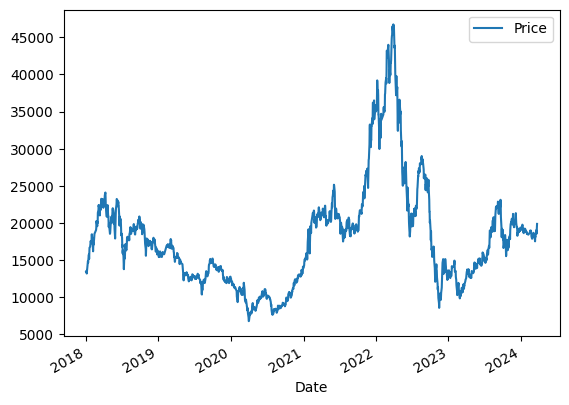

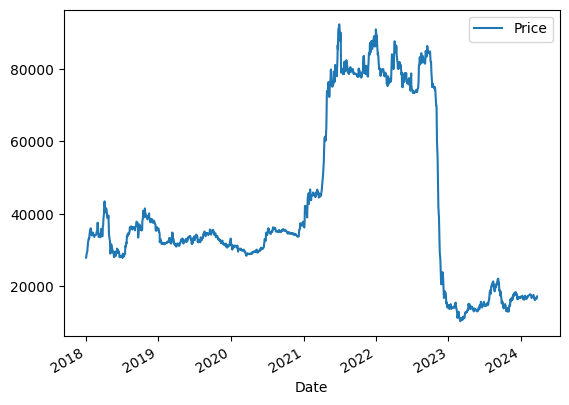

In [33]:
dig.plot()
dxg.plot()
nvl.plot()

In [103]:
#Chuẩn hóa dữ liệu
df1=nvl.reset_index()['Price']
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [121]:
#Chia train test 8:2
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [122]:
#Chuyển mảng giá trị thành ma trận 2D
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [123]:
#time_step = 6 tháng(khoảng 180 ngày)
time_step = 180
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest= create_dataset(test_data, time_step)

In [124]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)

(1060, 180)
(1060,)
(130, 180)
(130,)


In [125]:
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=X_train[0][0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

In [126]:
#tìm thông số phù hợp cho mô hình (giống auto arima)
kf = kf.em(X_train[0])

In [127]:
test_data.shape

(311, 1)

In [128]:
test_observed = test_data
#Sử dụng phương thức filter của mô hình Kalman Filter (kf) để dự đoán các giá trị trong test_observed
test_predicted, _ = kf.filter(test_observed)

In [129]:
test_predicted.shape

(311, 1)

In [130]:
#Chuyển đổi giá trị chuẩn hóa về dạng ban đầu
test_predicted=scaler.inverse_transform(test_predicted)
ytest=ytest.reshape(-1,1)
ytest=scaler.inverse_transform(test_data)

In [131]:
test_rmse = np.sqrt(np.mean((test_predicted - ytest)**2))
test_mae = mean_absolute_error(test_predicted, ytest)
test_mape = np.mean(np.abs(test_predicted - ytest)/np.abs(test_predicted))*100

In [132]:
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 536.3813356462827
Testing MAPE: 0.8204408125657042
Testing MAE: 136.92419980504644


In [133]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape[1]

251

In [134]:
test_data[60:].shape

(251, 1)

In [135]:
#Dự báo 30 ngày tiếp theo
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
for i in range(30):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        #print(x_input)
        yhat, _ = kf.filter(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat[-1].tolist())
    else:
        x_input = x_input.reshape(n_steps)
        yhat, _ = kf.filter(x_input)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat[-1].tolist())

Streaming output truncated to the last 5000 lines.
 [0.07548957]
 [0.07594411]
 [0.07784569]
 [0.0765792 ]
 [0.07668259]
 [0.08160288]
 [0.08292915]
 [0.1327575 ]
 [0.14831462]
 [0.15477559]
 [0.15623372]
 [0.15648504]
 [0.15726138]
 [0.1571872 ]
 [0.15759237]
 [0.15741814]
 [0.15765462]
 [0.15885213]
 [0.15960008]]
13 day input [0.04810268 0.05845389 0.05175605 0.04810268 0.05540942 0.05601832
 0.05236495 0.05053826 0.04079595 0.046276   0.04262263 0.04505821
 0.04688489 0.04932047 0.04018705 0.04018705 0.03288032 0.03348921
 0.03714258 0.04323153 0.04201374 0.03957816 0.04140484 0.03714258
 0.03714258 0.03592479 0.03775147 0.03592479 0.03653368 0.03592479
 0.03288032 0.03409811 0.03775147 0.03957816 0.04444932 0.04384042
 0.03957816 0.04079595 0.05236495 0.04810268 0.05297384 0.05297384
 0.06515174 0.06028058 0.06088947 0.05662721 0.04566711 0.05175605
 0.05175605 0.05358274 0.05175605 0.05662721 0.057845   0.06515174
 0.057845   0.05601832 0.05236495 0.05601832 0.05419163 0.05053826

In [136]:
# Chuyển danh sách thành mảng numpy
values_array = np.array(lst_output)
values_reshaped = values_array.reshape(-1, 1)

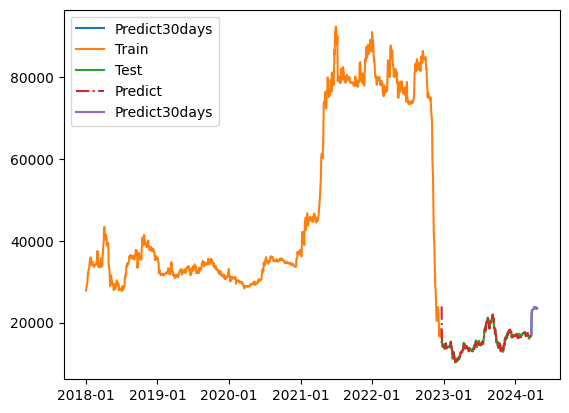

In [137]:
import matplotlib.dates as mdates

# Tính toán ngày tháng bắt đầu và kết thúc của dự báo 30 ngày tiếp theo
start_date = nvl.index[-1] + pd.Timedelta(days=1)
end_date = nvl.index[-1] + pd.Timedelta(days=30)

# Tạo mảng chứa ngày tháng trong khoảng thời gian đó
predict_dates = pd.date_range(start=start_date, end=end_date)

# Vẽ biểu đồ
plt.plot(predict_dates, scaler.inverse_transform(values_reshaped))

# Vẽ dữ liệu huấn luyện
plt.plot(nvl.index[:train_size], scaler.inverse_transform(train_data))

# Vẽ dữ liệu kiểm tra
plt.plot(nvl.index[train_size:train_size+test_size], scaler.inverse_transform(test_data),)

# Vẽ dự báo cho dữ liệu kiểm tra
plt.plot(nvl.index[train_size:train_size+test_size], test_predicted, linestyle='-.')

# Vẽ dự báo 30 ngày tiếp theo
plt.plot(predict_dates, scaler.inverse_transform(values_reshaped))

# Định dạng lại trục x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Hiển thị chú thích
plt.legend(['Predict30days', 'Train', 'Test', 'Predict', 'Predict30days'])

# Hiển thị biểu đồ
plt.show()
